# Dataset obtained from:

https://www.mammaldiversity.org/
- "MDD_v2.1_6801species.csv" file

# How to build the hierarchy or the knowledge graph?

## Extract only the major ranks from the dataset: (Common Name, species, genus, family, order, subclass)

In [ ]:
import pandas as pd

df = pd.read_csv("/content/species.csv")

# columns to keep
keep = [
    "mainCommonName",
    "sciName",
    "specificEpithet",
    "subgenus",
    "genus",
    "tribe",
    "subfamily",
    "family",
    "superfamily",
    "parvorder",
    "infraorder",
    "suborder",
    "order",
    "superorder",
    "magnorder",
    "infraclass",
    "subclass"
]

# rename columns
df_small = (
    df[keep]
      .drop_duplicates()
      .reset_index(drop=True)
      .rename(columns={
          "mainCommonName": "CommonName",
          "sciName": "Species",
          "specificEpithet":"SpecificEpithet",
          "subgenus": "Subgenus",
          "genus": "Genus",
          "tribe": "Tribe",
          "subfamily": "Subfamily",
          "family": "Family",
          "superfamily": "Superfamily",
          "parvorder": "Parvorder",
          "infraorder": "Infraorder",
          "suborder": "Suborder",
          "order": "Order",
          "superorder": "Superorder",
          "magnorder" : "Magnorder",
          'infraclass': "Infraclass",
          "subclass": "Subclass",
      })
)

# save
df_small.to_csv("/content/mammal_major_ranks.csv", index=False)


In [ ]:
print(df_small)

                              CommonName                   Species  \
0                               Platypus  Ornithorhynchus_anatinus   
1                   Short-beaked Echidna    Tachyglossus_aculeatus   
2     Attenborough's Long-beaked Echidna   Zaglossus_attenboroughi   
3            Eastern Long-beaked Echidna         Zaglossus_bartoni   
4            Western Long-beaked Echidna        Zaglossus_bruijnii   
...                                  ...                       ...   
6796                  Pygmy Beaked Whale     Mesoplodon_peruvianus   
6797            Stejneger's Beaked Whale     Mesoplodon_stejnegeri   
6798                 Spade-toothed Whale      Mesoplodon_traversii   
6799             Shepherd's Beaked Whale      Tasmacetus_shepherdi   
6800               Cuvier's Beaked Whale       Ziphius_cavirostris   

     SpecificEpithet Subgenus            Genus Tribe Subfamily  \
0           anatinus      NaN  Ornithorhynchus   NaN       NaN   
1          aculeatus      N

In [ ]:
import pandas as pd

columns = [
    "CommonName",
    "Species",
    "SpecificEpithet",
    "Subgenus",
    "Genus",
    "Tribe",
    "Subfamily",
    "Family",
    "Superfamily",
    "Parvorder",
    "Infraorder",
    "Suborder",
    "Order",
    "Superorder",
    "Magnorder",
    "Infraclass",
    "Subclass"
]

# Print number of unique values for each column, including column name
for col in columns:
    num_unique = df_small[col].nunique()
    print(f"# Column: {col}")
    print(f"Number of unique {col}: {num_unique}\n")


# Column: CommonName
Number of unique CommonName: 6801

# Column: Species
Number of unique Species: 6801

# Column: SpecificEpithet
Number of unique SpecificEpithet: 4778

# Column: Subgenus
Number of unique Subgenus: 180

# Column: Genus
Number of unique Genus: 1357

# Column: Tribe
Number of unique Tribe: 153

# Column: Subfamily
Number of unique Subfamily: 159

# Column: Family
Number of unique Family: 167

# Column: Superfamily
Number of unique Superfamily: 27

# Column: Parvorder
Number of unique Parvorder: 4

# Column: Infraorder
Number of unique Infraorder: 19

# Column: Suborder
Number of unique Suborder: 24

# Column: Order
Number of unique Order: 27

# Column: Superorder
Number of unique Superorder: 6

# Column: Magnorder
Number of unique Magnorder: 2

# Column: Infraclass
Number of unique Infraclass: 3

# Column: Subclass
Number of unique Subclass: 2



In [ ]:
# Print unique Subclasses
counts = df_small["Subclass"].value_counts(dropna=False)
print(counts)

Subclass
Theria        6796
Yinotheria       5
Name: count, dtype: int64


## Generate Embeddings (OpenAI text-embedding-3-large) - (embed species + commonName)

In [ ]:
import os, numpy as np
from tqdm import tqdm
from openai import OpenAI

In [ ]:
client = OpenAI(api_key="")

def get_openai_embeddings(texts, model="text-embedding-3-large", batch_size=96):
    all_embeds = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i : i + batch_size]

        response = client.embeddings.create(
            model=model,
            input=batch,
            encoding_format="float"
        )

        batch_sorted = sorted(response.data, key=lambda o: o.index)
        all_embeds.extend([item.embedding for item in batch_sorted])

    return np.asarray(all_embeds, dtype=np.float32)


In [ ]:
# embed species + commonName
df_small["text_for_embed"] = (
    df_small["Species"].str.replace("_", " ")
    + " | "
    + df_small["CommonName"]
)

texts = df_small["text_for_embed"].tolist()
emb   = get_openai_embeddings(texts)

print(emb.shape, emb.dtype)

Embedding: 100%|██████████| 71/71 [05:11<00:00,  4.39s/it]

(6801, 3072) float32


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

def reduce_dimensions(embeddings, method='pca', n_components=100, random_state=42):
    """
    Reduce the dimensionality of embeddings using the specified method.

    Parameters:
    -----------
    embeddings : numpy array
        The high-dimensional embeddings to reduce
    method : str
        Dimensionality reduction method: 'pca', 'tsne', or 'umap'
    n_components : int
        Number of dimensions in the reduced space
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    reduced_embeddings : numpy array
        The reduced-dimensional embeddings
    reducer : object
        The fitted reducer object (for applying to new data if needed)
    """
    print(f"Reducing dimensions from {embeddings.shape[1]} to {n_components} using {method.upper()}...")

    if method.lower() == 'pca':
        reducer = PCA(n_components=n_components, random_state=random_state)
        reduced_embeddings = reducer.fit_transform(embeddings)

        # Print explained variance
        explained_variance = reducer.explained_variance_ratio_.sum()
        print(f"Explained variance with {n_components} components: {explained_variance:.2%}")

    elif method.lower() == 'tsne':
        # t-SNE doesn't have a transform method for new data, so we return None as reducer
        reducer = TSNE(n_components=n_components, random_state=random_state)
        reduced_embeddings = reducer.fit_transform(embeddings)
        reducer = None  # Can't use TSNE for transforming new data

    elif method.lower() == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=random_state)
        reduced_embeddings = reducer.fit_transform(embeddings)

    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")

    print(f"Reduced embeddings shape: {reduced_embeddings.shape}")
    return reduced_embeddings, reducer

# Apply dimensionality reduction to your embeddings
# Choose the number of components and method based on your needs
reduced_emb, reducer = reduce_dimensions(
    emb,
    method='pca',  # Options: 'pca', 'tsne', 'umap'
    n_components=100  # Choose an appropriate number for your data
)

Reducing dimensions from 3072 to 100 using PCA...
Explained variance with 100 components: 62.80%
Reduced embeddings shape: (6801, 100)


# Perform hierarchical clustering on embeddings

1.   List item
2.   List item




In [ ]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

def hierarchical_cluster(embeddings, n_clusters=167, method='ward', metric='euclidean'):
    print(f"Performing hierarchical clustering with {method} linkage...")

    # For ward, only euclidean distance is supported
    if method == 'ward' and metric != 'euclidean':
        print("Warning: Ward linkage only supports euclidean distance. Switching to euclidean.")
        metric = 'euclidean'

    # Compute linkage matrix
    Z = linkage(embeddings, method=method, metric=metric)

    # Cut the tree to get n_clusters
    labels = fcluster(Z, t=n_clusters, criterion='maxclust') - 1  # Zero-based indexing

    # Compute silhouette score
    silhouette = silhouette_score(embeddings, labels)
    print(f"Silhouette score: {silhouette:.3f}")

    return labels, Z

# Apply hierarchical clustering on reduced embeddings
labels, Z = hierarchical_cluster(
    reduced_emb,
    n_clusters=167,
    method='ward'  # Options: 'ward', 'complete', 'average', 'single'
)

# Compute centroids in the reduced space
centroids = np.array([reduced_emb[labels == i].mean(axis=0) for i in range(np.max(labels) + 1)])

Performing hierarchical clustering with ward linkage...
Silhouette score: 0.140


# Method from [LLMEdgeRefine: Enhancing Text Clustering with LLM-Based Boundary Point Refinement](https://aclanthology.org/2024.emnlp-main.1025/)

## Reduce to 1 step of SPEC: "Super-point Enhanced Clustering"


In [ ]:
from sklearn.cluster import AgglomerativeClustering

def spec_step_reduced(X, labels, centroids, alpha=0.10):
    N = X.shape[0]
    super_points, super_idx = [], []
    remain_idx = []

    # 1) Build super-points per cluster
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        dists = np.linalg.norm(X[idx] - centroids[c], axis=1)
        take = int(max(1, np.ceil(alpha * len(idx))))
        far_idx = idx[np.argsort(dists)[-take:]]
        # Centroid of farthest points: super point
        super_points.append(X[far_idx].mean(0))
        super_idx.extend(far_idx)
        remain_idx.extend(np.setdiff1d(idx, far_idx))

    # 2) Make the dataset for agglomerative clustering
    X_new = np.vstack([X[remain_idx], np.vstack(super_points)])
    # First remain_idx rows are singletons, rest are super points
    n_clusters = len(set(labels))

    ac = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    new_labels = ac.fit_predict(X_new)

    # 3) Map back to original order
    final = np.empty(N, dtype=int)
    # a) Singletons
    final[remain_idx] = new_labels[:len(remain_idx)]
    # b) Far points look up by cluster
    offset = len(remain_idx)
    for j, c in enumerate(np.unique(labels)):
        lab_for_super = new_labels[offset + j]
        idx = np.where(labels == c)[0]
        dists = np.linalg.norm(X[idx] - centroids[c], axis=1)
        take = int(max(1, np.ceil(alpha * len(idx))))
        far_idx = idx[np.argsort(dists)[-take:]]
        final[far_idx] = lab_for_super

    # 4) Recompute centroids
    cents = np.vstack([X[final == k].mean(0) for k in range(n_clusters)])

    return final, cents


In [ ]:
# Apply SPEC refinement
print("Refining clusters with SPEC...")
for _ in range(5):  # Number of SPEC iterations
    labels, centroids = spec_step_reduced(reduced_emb, labels, centroids, alpha=0.10)


Refining clusters with SPEC...


## LACR (LLM-Assisted Cluster Refinement) Using GPT-4.1 on reduced dimensional embeddings


In [ ]:
def llm_assisted_refinement(reduced_emb, labels, centroids, df_small, client, prompt_template, beta=0.10, iterations=3):
    # Return True if LLM says 'keep', False if 'move'
    def llm_keep(label_to_desc, point_text, prompt_tmpl):
        prompt = prompt_tmpl.format(point=point_text, **label_to_desc)
        resp = client.chat.completions.create(
            model="gpt-4.1",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        reply = resp.choices[0].message.content.strip().upper()
        if reply == "KEEP":
            return True
        try:
            return int(reply)
        except ValueError:
            return True

    print(f"Performing LLM-assisted refinement for {iterations} iterations...")

    for _ in range(iterations):
        move_these = []  # Fresh start every loop
        # 1) Pick beta% farthest names per cluster
        unique_labels = np.unique(labels)

        # Map labels to their index in centroids array
        label_to_centroid_idx = {label: i for i, label in enumerate(unique_labels)}
        # Map centroid indices back to original labels
        centroid_idx_to_label = {i: label for i, label in enumerate(unique_labels)}

        for k in unique_labels:
            idx = np.where(labels == k)[0]
            d = np.linalg.norm(reduced_emb[idx] - centroids[label_to_centroid_idx[k]], axis=1)
            take = min(len(idx), int(max(1, np.ceil(beta * len(idx)))))
            move_these.extend(idx[np.argsort(d)[-take:]])

        # 2) For every candidate point, build 8-nearest cluster list
        for idx in move_these:
            # Cosine similarity to each centroid
            sims = (reduced_emb[idx] @ centroids.T) / (
                np.linalg.norm(reduced_emb[idx]) * np.linalg.norm(centroids, axis=1)
            )
            # Get indices of top 8 most similar centroids
            top8_centroid_indices = sims.argsort()[-8:][::-1]
            # Convert centroid indices to their corresponding cluster labels
            top8_labels = [centroid_idx_to_label[i] for i in top8_centroid_indices]

            # Cluster description: max 20 animals per cluster, with Species + CommonName
            desc = {}
            for i, label in enumerate(top8_labels):
                cluster_idx = np.where(labels == label)[0]
                # Compute distance to centroid
                centroid_idx = label_to_centroid_idx[label]
                dists = np.linalg.norm(reduced_emb[cluster_idx] - centroids[centroid_idx], axis=1)
                # Take 20 closest
                closest_idx = cluster_idx[np.argsort(dists)[:20]]
                subset = df_small.iloc[closest_idx][["Species", "CommonName"]]
                names = [f"Species: {row['Species']}, Common Name: {row['CommonName']}"
                         for _, row in subset.iterrows()]
                desc[f"c{i+1}"] = "\n".join(names)

            keep = llm_keep(desc, df_small.loc[idx, "text_for_embed"], prompt_template)
            if keep != True:
                # Convert selected index back to the actual label
                new_label = top8_labels[int(keep) - 1]
                labels[idx] = new_label

        # 3) After moves, recompute centroids
        unique_labels = np.unique(labels)
        centroids = np.vstack([reduced_emb[labels == k].mean(0) for k in unique_labels])

    return labels, centroids

# You would call this function with your prompt template and OpenAI client
# labels, centroids = llm_assisted_refinement(
#     reduced_emb, labels, centroids, df_small, client, prompt_template,
#     beta=0.10, iterations=3
# )

In [ ]:

prompt_template = """
You are refining clusters of animal names.
{point}

Below are 8 candidate cluster descriptions:

1. {c1}
2. {c2}
3. {c3}
4. {c4}
5. {c5}
6. {c6}
7. {c7}
8. {c8}

Choose the ONE cluster index that fits best, or say KEEP if it already fits.
Respond with just the number 1-8, or 'KEEP'.
"""


In [ ]:
labels, centroids = llm_assisted_refinement(
reduced_emb, labels, centroids, df_small, client, prompt_template,
 beta=0.10, iterations=3
)

Performing LLM-assisted refinement for 3 iterations...


# Evaluate and Inspect

In [ ]:
from sklearn.metrics import silhouette_score
sil = silhouette_score(emb, labels)
print(f"Silhouette = {sil:.3f}")

df_small["cluster"] = labels


Silhouette = 0.082


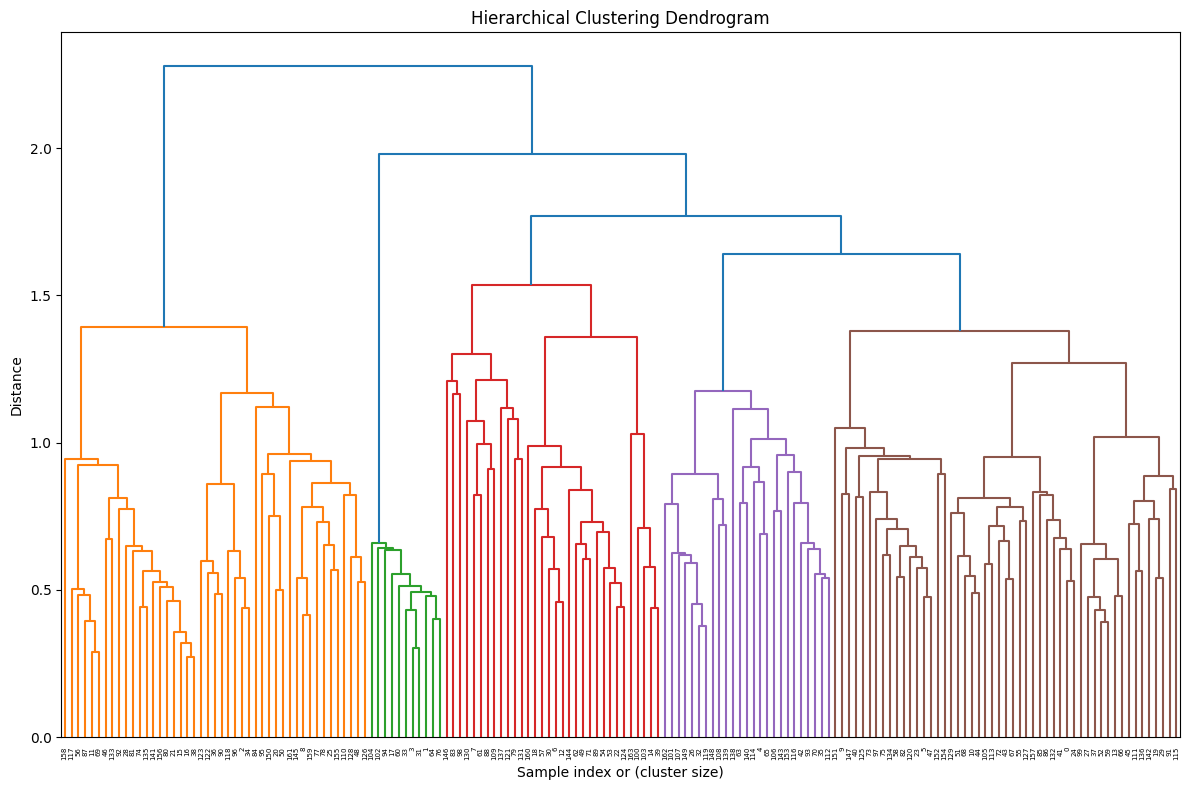

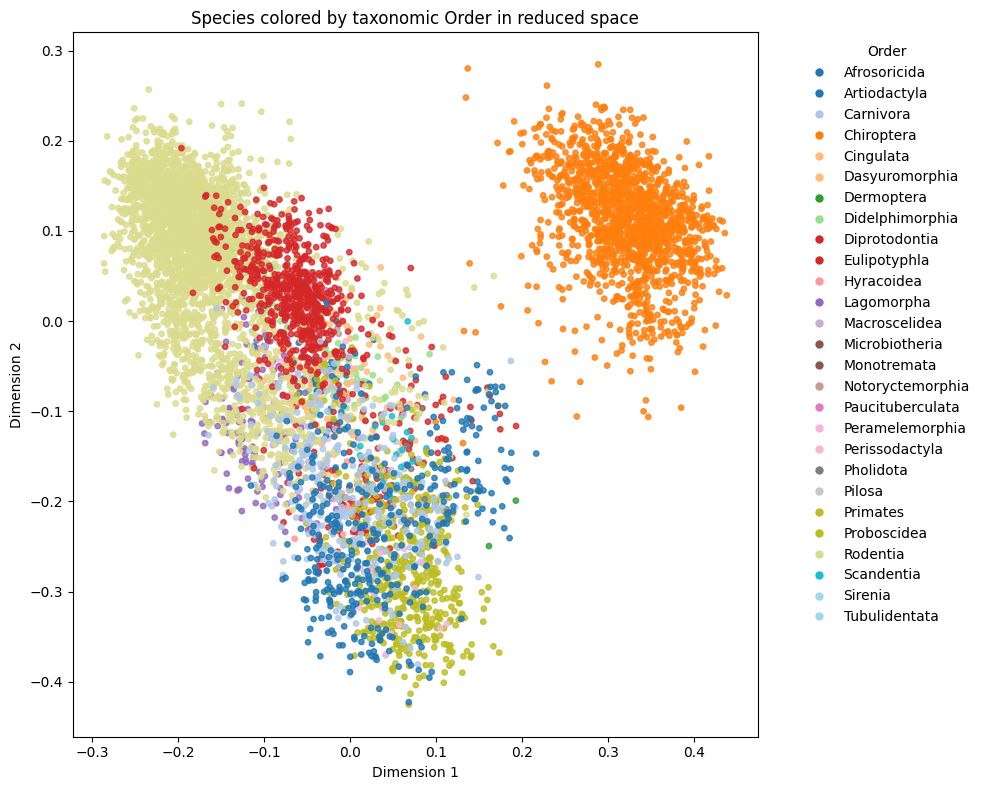

<ipython-input-38-f76bfae93289>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_cmap = plt.cm.get_cmap('tab20', num_clusters)


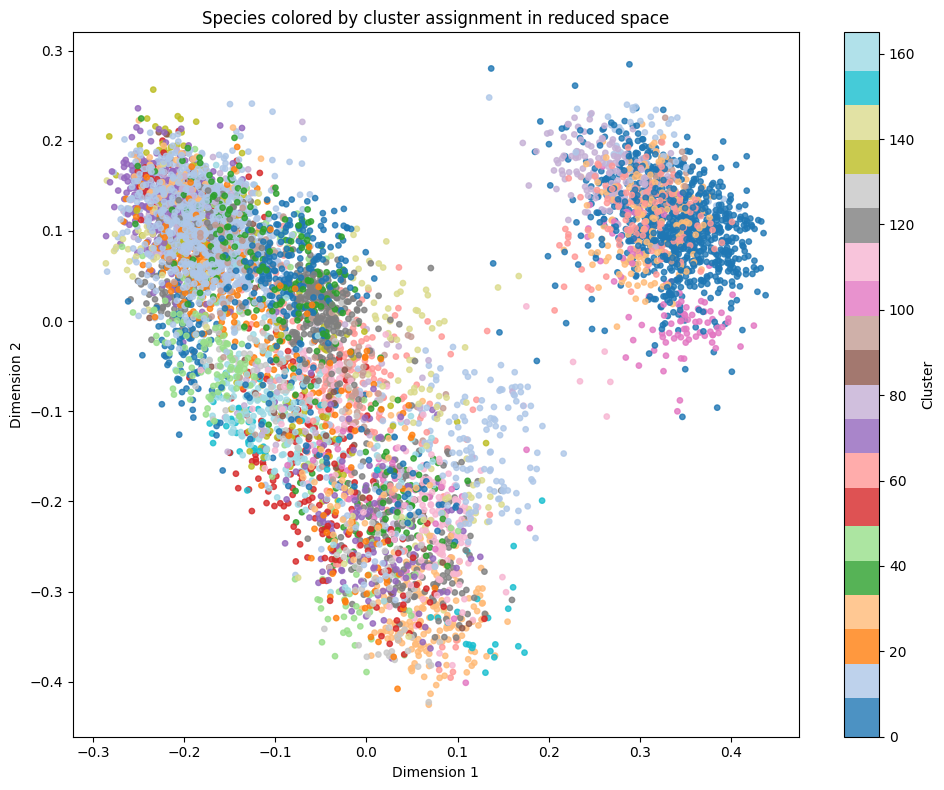

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from scipy.cluster.hierarchy import dendrogram

# 1. Visualize the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z, p=30, truncate_mode='level')  # Truncate for better visualization
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# 2. Visualize reduced dimensions colored by taxonomic order
if reduced_emb.shape[1] >= 2:  # We need at least 2 dimensions to plot
    # If we have more than 2 dimensions, use the first 2 for visualization
    plt.figure(figsize=(10, 8))

    orders = df_small["Order"].fillna("Unknown")
    order_codes = orders.astype("category").cat.codes
    unique_orders = orders.astype("category").cat.categories

    # Build a categorical colormap with enough distinct hues
    cmap = mpl.colors.ListedColormap(
        mpl.cm.tab20(np.linspace(0, 1, len(unique_orders)))
    )

    plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1],
                c=order_codes,
                cmap=cmap,
                s=15, alpha=.8)

    # Legend handles: use mlines.Line2D
    handles = [
        mlines.Line2D([0], [0], marker='o', linestyle='',
                     markerfacecolor=cmap(i), markersize=6,
                     markeredgewidth=0, label=ordr)
        for i, ordr in enumerate(unique_orders)
    ]

    plt.legend(handles=handles,
              bbox_to_anchor=(1.05, 1), loc='upper left',
              title="Order", frameon=False)

    plt.title("Species colored by taxonomic Order in reduced space")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.tight_layout()
    plt.show()

# 3. Visualize reduced dimensions colored by cluster assignment
if reduced_emb.shape[1] >= 2:
    plt.figure(figsize=(10, 8))

    # Use a discrete colormap with enough colors for all clusters
    num_clusters = len(np.unique(labels))
    cluster_cmap = plt.cm.get_cmap('tab20', num_clusters)

    scatter = plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1],
                c=labels,
                cmap=cluster_cmap,
                s=15, alpha=.8)

    plt.colorbar(scatter, label='Cluster')
    plt.title("Species colored by cluster assignment in reduced space")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.tight_layout()
    plt.show()

#Print dominant taxonomic groups for each cluster, showing the parent-child relationships.

================================================================================
OVERALL CLUSTERING EVALUATION
================================================================================
- Average Subclass purity across clusters: 0.999
- Average Order purity across clusters: 0.966
- Average Family purity across clusters: 0.866
- Average Genus purity across clusters: 0.538

Taxonomic capture by clusters:
- Subclass: 2/2 (100.0%) are dominant in at least one cluster
- Order: 22/27 (81.5%) are dominant in at least one cluster
- Family: 79/167 (47.3%) are dominant in at least one cluster
- Genus: 140/1357 (10.3%) are dominant in at least one cluster

In [ ]:
def print_dominant_taxonomy_per_cluster(df_small, labels, min_cluster_size=3):
    import pandas as pd
    import numpy as np
    from collections import Counter

    # Add cluster labels to the dataframe
    df = df_small.copy()
    df['Cluster'] = labels

    # Count clusters
    unique_clusters = sorted(np.unique(labels))

    print("\nDOMINANT TAXONOMIC GROUPS PER CLUSTER")
    print("="*80)

    for cluster_id in unique_clusters:
        # Get species in this cluster
        cluster_df = df[df['Cluster'] == cluster_id]
        cluster_size = len(cluster_df)

        # Skip small clusters
        if cluster_size < min_cluster_size:
            continue

        print(f"\nCluster {cluster_id} ({cluster_size} species):")

        # For each taxonomic level
        for level in ['Subclass', 'Order', 'Family', 'Genus']:
            # Count occurrences at this level
            level_counts = Counter(cluster_df[level].dropna())

            if level_counts:
                # Get the dominant taxon and its count
                sorted_counts = sorted(level_counts.items(), key=lambda x: x[1], reverse=True)
                dominant_taxon, count = sorted_counts[0]
                total = sum(count for _, count in sorted_counts)
                percentage = (count / total) * 100

                # Indentation to show hierarchy
                indent = "  " * (['Subclass', 'Order', 'Family', 'Genus'].index(level))

                # Print with clear parent-child relationships
                print(f"{indent}{level}: {dominant_taxon} ({count}/{total}, {percentage:.1f}%)")

                # For genus level, add some example species
                if level == 'Genus' and count > 0:
                    example_species = cluster_df[cluster_df[level] == dominant_taxon]['CommonName'].tolist()[:3]
                    if example_species:
                        example_text = ", ".join(example_species)
                        if len(example_species) < count:
                            example_text += f" and {count - len(example_species)} more"
                        print(f"{indent}  Examples: {example_text}")

# Run the simplified taxonomic analysis
print_dominant_taxonomy_per_cluster(df_small, labels)


DOMINANT TAXONOMIC GROUPS PER CLUSTER

Cluster 0 (22 species):
Subclass: Theria (22/22, 100.0%)
  Order: Carnivora (22/22, 100.0%)
    Family: Mustelidae (22/22, 100.0%)
      Genus: Mustela (17/22, 77.3%)
        Examples: Chinese Pygmy Weasel, Altai Mountain Weasel, Beringian Ermine and 14 more

Cluster 1 (183 species):
Subclass: Theria (183/183, 100.0%)
  Order: Chiroptera (183/183, 100.0%)
    Family: Rhinolophidae (111/183, 60.7%)
      Genus: Rhinolophus (111/183, 60.7%)
        Examples: Queensland Horseshoe Bat, Heuglin's Horseshoe Bat, Acuminate Horseshoe Bat and 108 more

Cluster 2 (188 species):
Subclass: Theria (188/188, 100.0%)
  Order: Eulipotyphla (188/188, 100.0%)
    Family: Soricidae (188/188, 100.0%)
      Genus: Sorex (84/188, 44.7%)
        Examples: Alpine Shrew, Alto Shrew, Valais Shrew and 81 more

Cluster 3 (676 species):
Subclass: Theria (676/676, 100.0%)
  Order: Chiroptera (675/676, 99.9%)
    Family: Phyllostomidae (197/676, 29.1%)
      Genus: Platyrrhinu

In [ ]:
def analyze_cluster_taxonomy(df_small, labels, output_taxonomic_levels=True, output_dominant_taxa=True, min_cluster_size=3):
    """
    Analyze the taxonomic composition of each cluster, showing parent-child
    relationships and dominance statistics.

    Parameters:
    -----------
    df_small : pandas DataFrame
        DataFrame containing taxonomic information for all species
    labels : numpy array
        Cluster assignments for each species
    output_taxonomic_levels : bool
        Whether to output detailed taxonomic level analysis for each cluster
    output_dominant_taxa : bool
        Whether to output the dominant taxa at each level for each cluster
    min_cluster_size : int
        Minimum cluster size to include in the analysis

    Returns:
    --------
    taxonomy_stats : dict
        Dictionary containing taxonomic statistics for each cluster
    """
    import pandas as pd
    import numpy as np
    from collections import Counter

    # Taxonomic levels from most general to most specific
    taxonomic_levels = ['Subclass', 'Order', 'Family', 'Genus']

    # Add cluster labels to the dataframe
    df = df_small.copy()
    df['Cluster'] = labels

    # Count clusters
    unique_clusters = np.unique(labels)

    # Create a dictionary to store results
    taxonomy_stats = {}

    print("\n" + "="*80)
    print("TAXONOMIC ANALYSIS OF CLUSTERS")
    print("="*80)

    for cluster_id in unique_clusters:
        # Get species in this cluster
        cluster_df = df[df['Cluster'] == cluster_id]
        cluster_size = len(cluster_df)

        # Skip small clusters if requested
        if cluster_size < min_cluster_size:
            continue

        print(f"\n\n{'-'*80}")
        print(f"CLUSTER {cluster_id} - {cluster_size} species")
        print(f"{'-'*80}")

        # Store statistics for this cluster
        cluster_stats = {'size': cluster_size}

        # Analyze each taxonomic level
        for i, level in enumerate(taxonomic_levels):
            # Count occurrences of each taxon at this level
            taxa_counter = Counter(cluster_df[level].dropna())
            total_with_data = sum(taxa_counter.values())

            # Sort taxa by count, descending
            sorted_taxa = sorted(taxa_counter.items(), key=lambda x: x[1], reverse=True)

            # Store top taxa and their counts
            cluster_stats[level] = sorted_taxa

            if output_taxonomic_levels:
                print(f"\n● {level} distribution:")

                # Calculate how many taxa to display (all if fewer than 10, otherwise top 10)
                display_count = min(len(sorted_taxa), 10)

                for j, (taxon, count) in enumerate(sorted_taxa[:display_count]):
                    percentage = (count / total_with_data) * 100
                    # Mark the dominant taxon
                    prefix = "➤" if j == 0 else " "
                    print(f"  {prefix} {taxon}: {count}/{total_with_data} ({percentage:.1f}%)")

                # Show "and more" if we have more than 10 taxa
                if len(sorted_taxa) > 10:
                    remaining = len(sorted_taxa) - 10
                    print(f"   ... and {remaining} more {level.lower()} taxa")

        if output_dominant_taxa:
            # Now create a hierarchical view of the dominant taxa
            print("\n● Taxonomic hierarchy in this cluster:")

            # Start from the highest level and work down
            current_level = taxonomic_levels[0]
            if cluster_stats[current_level]:
                dominant_taxon, count = cluster_stats[current_level][0]
                total = sum(count for _, count in cluster_stats[current_level])
                percentage = (count / total) * 100

                print(f"  {current_level}: {dominant_taxon} ({count}/{total}, {percentage:.1f}%)")

                # For each subsequent level, filter by the dominant taxon of the previous level
                for i in range(1, len(taxonomic_levels)):
                    prev_level = taxonomic_levels[i-1]
                    current_level = taxonomic_levels[i]

                    # Get the dominant taxon from the previous level
                    prev_dominant = cluster_stats[prev_level][0][0]

                    # Filter the dataframe for species with this parent taxon
                    filtered_df = cluster_df[cluster_df[prev_level] == prev_dominant]

                    # Count occurrences at the current level
                    current_counter = Counter(filtered_df[current_level].dropna())

                    if current_counter:
                        # Sort by count
                        current_sorted = sorted(current_counter.items(), key=lambda x: x[1], reverse=True)
                        dominant_taxon, count = current_sorted[0]
                        total = sum(count for _, count in current_sorted)
                        percentage = (count / total) * 100

                        # Indent to show hierarchy
                        indent = "  " + "  " * i
                        print(f"{indent}{current_level}: {dominant_taxon} ({count}/{total}, {percentage:.1f}%)")

                        # For the lowest level (Genus), also show some example species
                        if current_level == taxonomic_levels[-1] and count > 0:
                            example_species = filtered_df[filtered_df[current_level] == dominant_taxon]['CommonName'].tolist()[:3]
                            if example_species:
                                example_text = ", ".join(example_species)
                                if len(example_species) < count:
                                    example_text += f" and {count - len(example_species)} more"
                                print(f"{indent}  Example species: {example_text}")

        # Calculate purity scores for this cluster
        print("\n● Taxonomic purity scores:")
        for level in taxonomic_levels:
            taxa_counter = Counter(cluster_df[level].dropna())
            if taxa_counter:
                dominant_taxon, dominant_count = sorted(taxa_counter.items(), key=lambda x: x[1], reverse=True)[0]
                total_with_data = sum(taxa_counter.values())
                purity = dominant_count / total_with_data
                cluster_stats[f"{level}_purity"] = purity
                print(f"  {level} purity: {purity:.2f} ({dominant_taxon})")

        # Store in the main dictionary
        taxonomy_stats[cluster_id] = cluster_stats

        # Show some example species from this cluster
        print("\n● Example species in this cluster:")
        examples = cluster_df.sample(min(5, cluster_size))[['CommonName', 'Species', 'Order', 'Family', 'Genus']]
        for _, row in examples.iterrows():
            print(f"  {row['CommonName']} ({row['Species']}) - {row['Order']} > {row['Family']} > {row['Genus']}")

    # Print overall statistics
    print("\n" + "="*80)
    print("OVERALL CLUSTERING EVALUATION")
    print("="*80)

    # Calculate average purity scores across all analyzed clusters
    avg_purity = {}
    for level in taxonomic_levels:
        purity_scores = [stats[f"{level}_purity"] for cluster_id, stats in taxonomy_stats.items()
                         if f"{level}_purity" in stats]
        if purity_scores:
            avg_purity[level] = sum(purity_scores) / len(purity_scores)
            print(f"Average {level} purity across clusters: {avg_purity[level]:.3f}")

    # Evaluate how well clusters capture taxonomic groups
    print("\nTaxonomic capture by clusters:")
    for level in taxonomic_levels:
        # Count unique taxa at this level
        unique_taxa = df[level].nunique()

        # Count how many clusters have this taxon as dominant
        dominant_taxa = set()
        for cluster_id, stats in taxonomy_stats.items():
            if level in stats and stats[level]:
                dominant_taxa.add(stats[level][0][0])

        coverage = len(dominant_taxa) / unique_taxa if unique_taxa > 0 else 0
        print(f"{level}: {len(dominant_taxa)}/{unique_taxa} ({coverage:.1%}) are dominant in at least one cluster")

    return taxonomy_stats

# Run the taxonomic analysis on your clusters
taxonomy_stats = analyze_cluster_taxonomy(df_small, labels)

Streaming output truncated to the last 5000 lines.

● Taxonomic hierarchy in this cluster:
  Subclass: Theria (12/12, 100.0%)
    Order: Carnivora (9/12, 75.0%)
      Family: Mustelidae (6/9, 66.7%)
        Genus: Melogale (6/6, 100.0%)
          Example species: Cuc Phuong Ferret-badger, Bornean Ferret-badger, Small-toothed Ferret-badger and 3 more

● Taxonomic purity scores:
  Subclass purity: 1.00 (Theria)
  Order purity: 0.75 (Carnivora)
  Family purity: 0.50 (Mustelidae)
  Genus purity: 0.50 (Melogale)

● Example species in this cluster:
  Formosan Ferret-badger (Melogale_subaurantiaca) - Carnivora > Mustelidae > Melogale
  Cuc Phuong Ferret-badger (Melogale_cucphuongensis) - Carnivora > Mustelidae > Melogale
  Small-toothed Ferret-badger (Melogale_moschata) - Carnivora > Mustelidae > Melogale
  Sunda Stink Badger (Mydaus_javanensis) - Carnivora > Mephitidae > Mydaus
  Large-toothed Ferret-badger (Melogale_personata) - Carnivora > Mustelidae > Melogale


--------------------------

### Print Common Name, Order, Family per each cluster

In [ ]:
# Make sure rows inside a cluster are ordered predictably
tmp = df_small.sort_values(["cluster", "Species"])

# How many examples per cluster?
n = 5

for c in sorted(tmp["cluster"].unique()):      # 0, 1, 2, …
    print(f"\n— Cluster {c} —")                # header line
    block = tmp[tmp["cluster"] == c].head(n)   # first n rows of this cluster
    print(block[["CommonName", "Order", "Family"]])    # choose columns to display


— Cluster 0 —
                CommonName      Order      Family
6152       Japanese Badger  Carnivora  Mustelidae
6153      Caucasian Badger  Carnivora  Mustelidae
6154          Asian Badger  Carnivora  Mustelidae
6155       European Badger  Carnivora  Mustelidae
6157  Chinese Pygmy Weasel  Carnivora  Mustelidae

— Cluster 1 —
                           CommonName       Order          Family
4808               Aba Round-leaf Bat  Chiroptera  Hipposideridae
4809           Ha Long Round-leaf Bat  Chiroptera  Hipposideridae
4810  Philippine Dusky Round-leaf Bat  Chiroptera  Hipposideridae
4811   Great Himalayan Round-leaf Bat  Chiroptera  Hipposideridae
4812      Common Dusky Round-leaf Bat  Chiroptera  Hipposideridae

— Cluster 2 —
                         CommonName         Order     Family
4323    Southern Short-tailed Shrew  Eulipotyphla  Soricidae
4324    Elliot's Short-tailed Shrew  Eulipotyphla  Soricidae
4325  Everglades Short-tailed Shrew  Eulipotyphla  Soricidae
4326   Sherman'

In [ ]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

def extract_hierarchy_from_linkage(Z, labels=None):
    """
    Extract a hierarchical structure from a linkage matrix.

    Parameters:
    -----------
    Z : numpy array
        The linkage matrix from hierarchical clustering
    labels : list or array, optional
        The labels for the leaf nodes. If None, indices will be used.

    Returns:
    --------
    hierarchy : dict
        Dictionary representing the hierarchical structure
    nx_graph : networkx.DiGraph
        Directed graph representation of the hierarchy
    """
    n_samples = Z.shape[0] + 1

    # If no labels are provided, use indices
    if labels is None:
        labels = [str(i) for i in range(n_samples)]

    # Create a directed graph
    G = nx.DiGraph()

    # Add leaf nodes (original samples)
    for i, label in enumerate(labels):
        G.add_node(i, label=label, level=0, type='leaf')

    # Add internal nodes from the linkage matrix
    for i, (left, right, dist, count) in enumerate(Z):
        node_id = n_samples + i
        left_id = int(left)
        right_id = int(right)

        # Add the new node
        G.add_node(node_id, label=f'Cluster_{i}', level=dist, type='internal', size=count)

        # Add edges from this node to its children
        G.add_edge(node_id, left_id)
        G.add_edge(node_id, right_id)

    # Build the hierarchy dictionary
    hierarchy = {}
    root = n_samples + Z.shape[0] - 1  # The last merged node is the root

    def _build_hierarchy(node_id):
        if G.nodes[node_id]['type'] == 'leaf':
            return labels[node_id]

        children = list(G.successors(node_id))
        return {
            'name': G.nodes[node_id]['label'],
            'size': G.nodes[node_id]['size'],
            'level': G.nodes[node_id]['level'],
            'children': [_build_hierarchy(child) for child in children]
        }

    hierarchy = _build_hierarchy(root)

    return hierarchy, G



In [ ]:
# Assuming Z is your linkage matrix and df_small['Species'] contains the species names
hierarchy, hierarchy_graph = extract_hierarchy_from_linkage(
    Z,
    labels=df_small['Species'].tolist()
)

In [ ]:
def annotate_clusters_with_taxonomy(G, df_small, labels):
    """
    Annotate clusters with predominant taxonomic information.

    Parameters:
    -----------
    G : networkx.DiGraph
        Directed graph representation of the hierarchy
    df_small : pandas DataFrame
        DataFrame containing taxonomic information
    labels : list or array
        Cluster assignments for each sample

    Returns:
    --------
    G_annotated : networkx.DiGraph
        Annotated directed graph
    """
    G_annotated = G.copy()

    # Helper function to get the predominant taxonomic group
    def get_predominant(node_id, tax_column):
        if G.nodes[node_id]['type'] == 'leaf':
            idx = node_id
            return df_small.iloc[idx][tax_column]

        # For internal nodes, gather all descendant leaves
        descendants = []

        def collect_leaves(n):
            if G.nodes[n]['type'] == 'leaf':
                descendants.append(n)
            else:
                for child in G.successors(n):
                    collect_leaves(child)

        collect_leaves(node_id)

        # Count taxonomic groups among descendants
        counts = df_small.iloc[descendants][tax_column].value_counts()
        if len(counts) > 0:
            return counts.index[0]  # Return the most common
        return "Unknown"

    # Annotate each internal node with taxonomic information
    for node in G_annotated.nodes():
        if G_annotated.nodes[node]['type'] == 'internal':
            order = get_predominant(node, 'Order')
            family = get_predominant(node, 'Family')
            genus = get_predominant(node, 'Genus')

            G_annotated.nodes[node]['order'] = order
            G_annotated.nodes[node]['family'] = family
            G_annotated.nodes[node]['genus'] = genus

            # Create a more informative label
            if node == max(G_annotated.nodes()):  # Root node
                G_annotated.nodes[node]['label'] = 'Mammalia'
            elif G_annotated.nodes[node]['level'] > 1.5:  # Higher levels might be orders
                G_annotated.nodes[node]['label'] = f'Order: {order}'
            elif G_annotated.nodes[node]['level'] > 1.0:  # Mid levels might be families
                G_annotated.nodes[node]['label'] = f'Family: {family}'
            else:  # Lower levels might be genera
                G_annotated.nodes[node]['label'] = f'Genus: {genus}'

    return G_annotated

# Annotate the hierarchy graph with taxonomic information
annotated_graph = annotate_clusters_with_taxonomy(hierarchy_graph, df_small, labels)

In [ ]:
def extract_ontology_levels(Z, df_small, n_levels=5):
    """
    Extract multiple levels of clustering to create an ontology.

    Parameters:
    -----------
    Z : numpy array
        The linkage matrix from hierarchical clustering
    df_small : pandas DataFrame
        DataFrame containing taxonomic information
    n_levels : int
        Number of levels to extract from the hierarchy

    Returns:
    --------
    ontology : dict
        Dictionary representing the ontology at different levels
    """
    max_dist = Z[-1, 2]  # Maximum distance in the linkage matrix

    # Define distance thresholds for different levels
    thresholds = np.linspace(max_dist/n_levels, max_dist, n_levels)

    ontology = {}
    for i, threshold in enumerate(thresholds):
        level_name = f"Level_{i+1}"

        # Get clusters at this threshold
        labels = fcluster(Z, threshold, criterion='distance') - 1  # 0-based indexing

        # Create a mapping of each cluster to its taxonomic composition
        clusters = {}
        for cluster_id in np.unique(labels):
            cluster_indices = np.where(labels == cluster_id)[0]
            cluster_df = df_small.iloc[cluster_indices]

            # Count taxonomic groups within this cluster
            order_counts = cluster_df['Order'].value_counts().to_dict()
            family_counts = cluster_df['Family'].value_counts().to_dict()
            genus_counts = cluster_df['Genus'].value_counts().to_dict()

            # Determine predominant taxonomic groups
            predominant_order = max(order_counts.items(), key=lambda x: x[1])[0] if order_counts else "Unknown"
            predominant_family = max(family_counts.items(), key=lambda x: x[1])[0] if family_counts else "Unknown"

            # Create a descriptive name for the cluster
            if i < 2:  # Higher levels (more general)
                cluster_name = f"Order: {predominant_order}"
            elif i < 4:  # Mid levels
                cluster_name = f"Family: {predominant_family}"
            else:  # Lower levels (more specific)
                # For the most specific level, we might list the top genera
                top_genera = sorted(genus_counts.items(), key=lambda x: x[1], reverse=True)[:3]
                genera_names = [genus for genus, _ in top_genera]
                cluster_name = f"Genera: {', '.join(genera_names)}"

            # Store cluster information
            clusters[cluster_id] = {
                'name': cluster_name,
                'size': len(cluster_indices),
                'order_composition': order_counts,
                'family_composition': family_counts,
                'species': cluster_df['Species'].tolist(),
                'common_names': cluster_df['CommonName'].tolist()
            }

        ontology[level_name] = {
            'threshold': threshold,
            'n_clusters': len(clusters),
            'clusters': clusters
        }

    return ontology

# Extract the ontology at different levels
ontology = extract_ontology_levels(Z, df_small, n_levels=5)

In [ ]:
def build_taxonomic_ontology(df_small, final_labels):
    """
    Build a taxonomic ontology based on the species data and clustering results.

    Parameters:
    -----------
    df_small : pandas DataFrame
        DataFrame containing taxonomic information
    final_labels : numpy array
        Final cluster assignments

    Returns:
    --------
    ontology : dict
        Hierarchical dictionary representing the taxonomic ontology
    """
    # Start with the root - all mammals
    ontology = {
        'name': 'Mammalia',
        'children': []
    }

    # Function to add a species to the ontology
    def add_species_to_ontology(ontology_node, species_row):
        # Extract taxonomic information
        subclass = species_row['Subclass'] if pd.notna(species_row['Subclass']) else 'Unknown Subclass'
        order = species_row['Order'] if pd.notna(species_row['Order']) else 'Unknown Order'
        family = species_row['Family'] if pd.notna(species_row['Family']) else 'Unknown Family'
        genus = species_row['Genus'] if pd.notna(species_row['Genus']) else 'Unknown Genus'
        species = species_row['Species']
        common_name = species_row['CommonName']
        cluster = species_row['cluster']

        # Find or create subclass node
        subclass_node = next((node for node in ontology_node['children'] if node['name'] == subclass), None)
        if subclass_node is None:
            subclass_node = {'name': subclass, 'type': 'subclass', 'children': []}
            ontology_node['children'].append(subclass_node)

        # Find or create order node
        order_node = next((node for node in subclass_node['children'] if node['name'] == order), None)
        if order_node is None:
            order_node = {'name': order, 'type': 'order', 'children': []}
            subclass_node['children'].append(order_node)

        # Find or create family node
        family_node = next((node for node in order_node['children'] if node['name'] == family), None)
        if family_node is None:
            family_node = {'name': family, 'type': 'family', 'children': []}
            order_node['children'].append(family_node)

        # Find or create genus node
        genus_node = next((node for node in family_node['children'] if node['name'] == genus), None)
        if genus_node is None:
            genus_node = {'name': genus, 'type': 'genus', 'children': []}
            family_node['children'].append(genus_node)

        # Add species node
        species_node = {
            'name': species,
            'common_name': common_name,
            'type': 'species',
            'cluster': int(cluster)
        }
        genus_node['children'].append(species_node)

    # Add each species to the ontology
    for _, row in df_small.iterrows():
        add_species_to_ontology(ontology, row)

    return ontology

# Build the full taxonomic ontology
taxonomic_ontology = build_taxonomic_ontology(df_small, labels)

In [ ]:
def print_ontology(ontology, max_depth=4, indent=0, max_children=5):
    """
    Print the ontology in a hierarchical format.

    Parameters:
    -----------
    ontology : dict
        The ontology to print
    max_depth : int
        Maximum depth to print
    indent : int
        Current indentation level
    max_children : int
        Maximum number of children to print at each level
    """
    if indent > max_depth:
        return

    # Print the current node
    indent_str = "  " * indent
    if 'type' in ontology:
        print(f"{indent_str}- {ontology['name']} ({ontology['type']})")
    else:
        print(f"{indent_str}- {ontology['name']}")

    # Print children
    if 'children' in ontology and ontology['children']:
        children = ontology['children']

        # Sort children by name for better readability
        children = sorted(children, key=lambda x: x['name'])

        # Print only a subset of children if there are too many
        if len(children) > max_children and indent > 0:
            selected_children = children[:max_children]
            print(f"{indent_str}  [Showing {max_children} of {len(children)} children]")
        else:
            selected_children = children

        for child in selected_children:
            print_ontology(child, max_depth, indent + 1, max_children)

# Print the taxonomic ontology
print("Taxonomic Ontology:")
print_ontology(taxonomic_ontology, max_depth=4, max_children=8)

Taxonomic Ontology:
- Mammalia
  - Theria (subclass)
    [Showing 8 of 26 children]
    - Afrosoricida (order)
      - Chrysochloridae (family)
        [Showing 8 of 10 children]
        - Amblysomus (genus)
        - Calcochloris (genus)
        - Carpitalpa (genus)
        - Chlorotalpa (genus)
        - Chrysochloris (genus)
        - Chrysospalax (genus)
        - Cryptochloris (genus)
        - Eremitalpa (genus)
      - Potamogalidae (family)
        - Micropotamogale (genus)
        - Potamogale (genus)
      - Tenrecidae (family)
        - Echinops (genus)
        - Geogale (genus)
        - Hemicentetes (genus)
        - Microgale (genus)
          [Showing 8 of 21 children]
        - Nesogale (genus)
        - Oryzorictes (genus)
        - Setifer (genus)
        - Tenrec (genus)
    - Artiodactyla (order)
      [Showing 8 of 23 children]
      - Antilocapridae (family)
        - Antilocapra (genus)
      - Balaenidae (family)
        - Balaena (genus)
        - Eubalaena (ge

In [ ]:
def export_ontology(ontology, output_prefix):
    """
    Export the ontology to various formats.

    Parameters:
    -----------
    ontology : dict
        The ontology to export
    output_prefix : str
        Prefix for output files
    """
    import json
    import networkx as nx

    # Export to JSON
    with open(f"{output_prefix}_ontology.json", 'w') as f:
        json.dump(ontology, f, indent=2)

    # Export to NetworkX graph and then to GraphML
    G = nx.DiGraph()

    def add_to_graph(node, parent=None):
        node_id = node.get('name', 'unknown')
        if parent is not None:
            parent_id = parent.get('name', 'unknown')
            # Add suffix to ensure uniqueness
            if 'type' in node:
                node_id = f"{node_id}_{node['type']}"
            if 'type' in parent:
                parent_id = f"{parent_id}_{parent['type']}"

        # Add node attributes
        attrs = {k: v for k, v in node.items() if k not in ['children']}
        G.add_node(node_id, **attrs)

        # Add edge if parent exists
        if parent is not None:
            G.add_edge(parent_id, node_id)

        # Process children
        if 'children' in node:
            for child in node['children']:
                add_to_graph(child, node)

    add_to_graph(ontology)

    # Export to GraphML
    nx.write_graphml(G, f"{output_prefix}_ontology.graphml")

    # Export to CSV format for Neo4j import
    nodes_data = []
    edges_data = []

    for node, attrs in G.nodes(data=True):
        nodes_data.append({'id': node, **attrs})

    for source, target in G.edges():
        edges_data.append({'source': source, 'target': target, 'type': 'HAS_CHILD'})

    # Create DataFrames
    nodes_df = pd.DataFrame(nodes_data)
    edges_df = pd.DataFrame(edges_data)

    # Export to CSV
    nodes_df.to_csv(f"{output_prefix}_nodes.csv", index=False)
    edges_df.to_csv(f"{output_prefix}_edges.csv", index=False)

    print(f"Ontology exported to {output_prefix}_ontology.json")
    print(f"Graph exported to {output_prefix}_ontology.graphml")
    print(f"Node and edge data exported to {output_prefix}_nodes.csv and {output_prefix}_edges.csv")

# Export the taxonomic ontology
export_ontology(taxonomic_ontology, "mammal_taxonomy")

Ontology exported to mammal_taxonomy_ontology.json
Graph exported to mammal_taxonomy_ontology.graphml
Node and edge data exported to mammal_taxonomy_nodes.csv and mammal_taxonomy_edges.csv


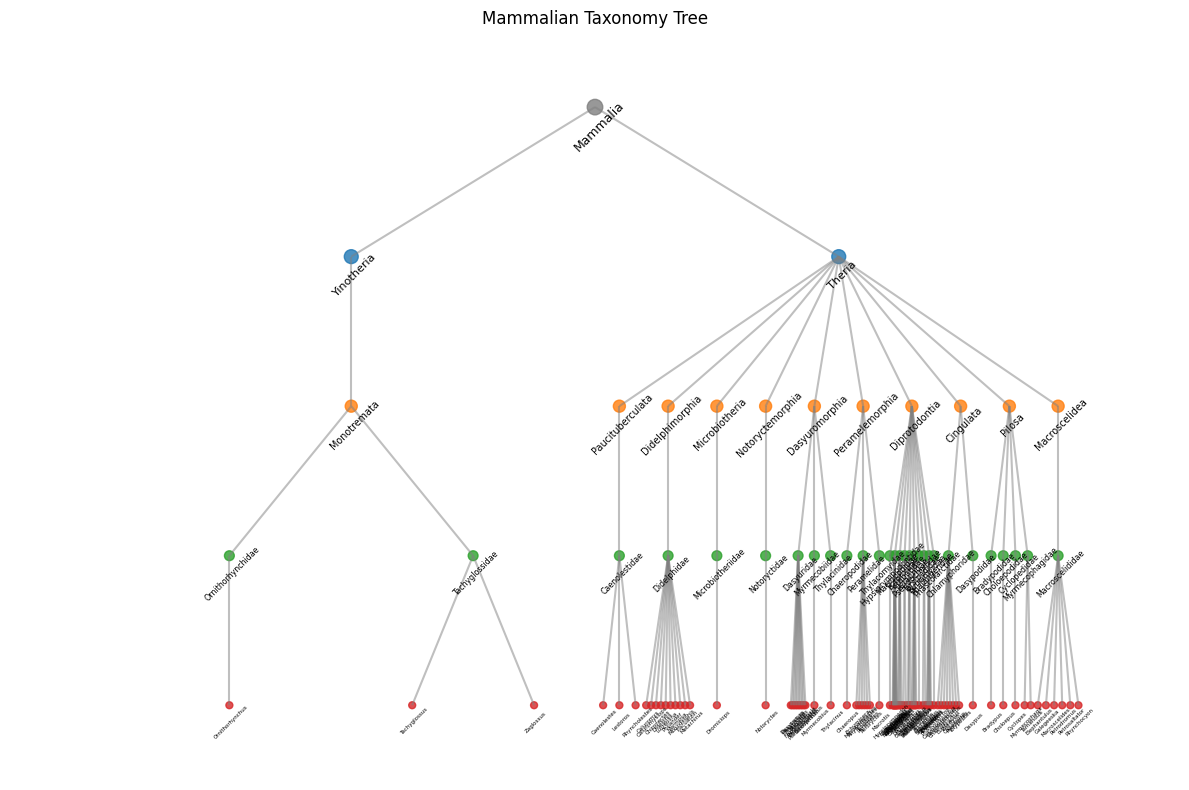

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

def plot_taxonomy_tree(ontology, max_depth=4, figsize=(12, 8)):
    """
    Create a simple tree visualization of the taxonomy.

    Parameters:
    -----------
    ontology : dict
        The ontology to visualize
    max_depth : int
        Maximum depth to display
    figsize : tuple
        Figure size
    """
    plt.figure(figsize=figsize)

    # Track all nodes and their positions
    nodes = []
    positions = []
    labels = []
    colors = []
    node_sizes = []
    lines = []

    # Color mapping for node types
    color_map = {
        'subclass': 'tab:blue',
        'order': 'tab:orange',
        'family': 'tab:green',
        'genus': 'tab:red',
        'species': 'tab:purple'
    }

    # Recursive function to process nodes
    def process_node(node, x, y, width, depth=0):
        if depth > max_depth:
            return

        # Store node information
        nodes.append((x, y))
        labels.append(node['name'])

        # Determine node color and size
        node_type = node.get('type', 'unknown')
        colors.append(color_map.get(node_type, 'tab:gray'))

        # Larger nodes for higher levels
        node_sizes.append(100 * (max_depth - depth + 1) / max_depth)

        # Process children
        if 'children' in node and node['children'] and depth < max_depth:
            children = node['children']
            n_children = len(children)

            # If too many children, sample some
            if n_children > 10:
                children = children[:10]
                n_children = 10

            # Calculate positions for children
            child_width = width / n_children

            for i, child in enumerate(children):
                child_x = x - width/2 + child_width/2 + i*child_width
                child_y = y - 1  # Move down one level

                # Add line connecting parent to child
                lines.append([(x, y), (child_x, child_y)])

                # Process child node
                process_node(child, child_x, child_y, child_width, depth + 1)

    # Start with the root node
    process_node(ontology, 0, 0, 10)

    # Plot the tree
    plt.scatter(*zip(*nodes), s=node_sizes, c=colors, alpha=0.8)

    # Add node labels
    for (x, y), label, size in zip(nodes, labels, node_sizes):
        # Adjust label size based on node size
        font_size = np.sqrt(size) * 0.8
        plt.text(x, y-0.1, label, ha='center', va='top', fontsize=font_size,
                 rotation=45, rotation_mode='anchor')

    # Add connecting lines
    line_segments = LineCollection(lines, colors='gray', alpha=0.5, linestyle='-')
    plt.gca().add_collection(line_segments)

    # Set plot limits and remove axes
    plt.xlim(-6, 6)
    plt.ylim(-max_depth-0.5, 0.5)
    plt.axis('off')
    plt.title('Mammalian Taxonomy Tree')
    plt.tight_layout()
    plt.show()

# Visualize the taxonomy tree
plot_taxonomy_tree(taxonomic_ontology, max_depth=4)

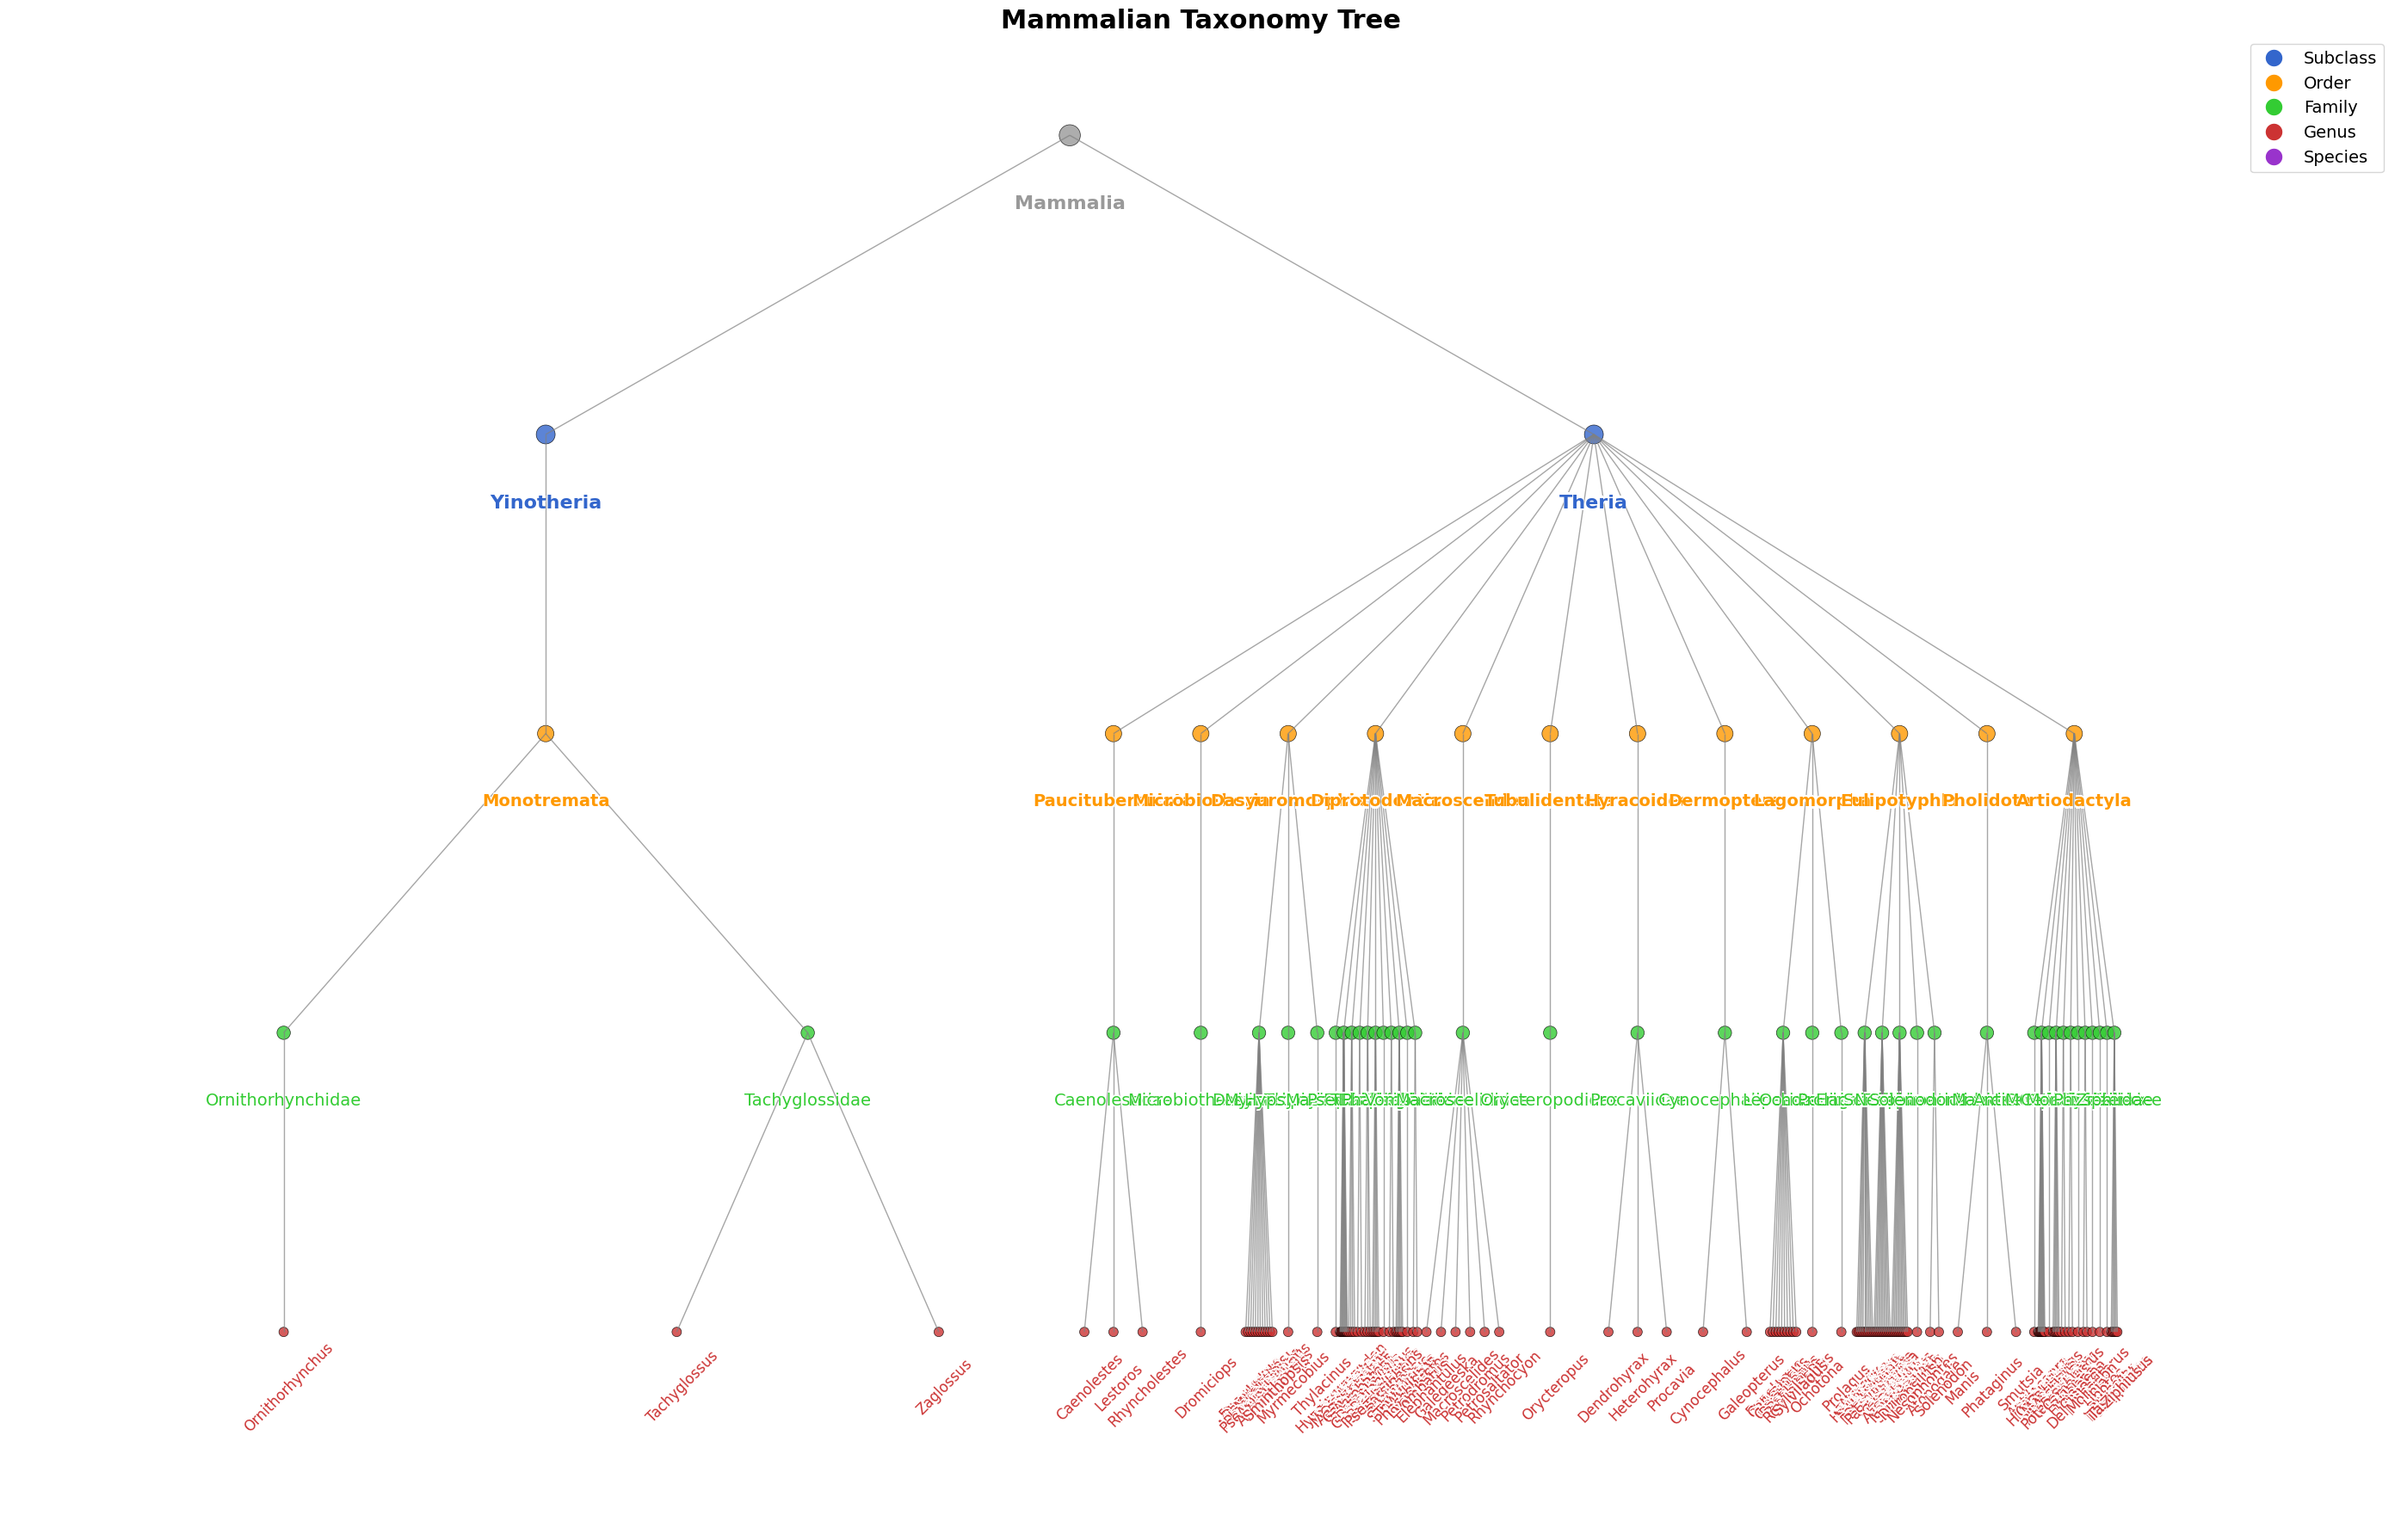

In [ ]:
def plot_taxonomy_tree(ontology, max_depth=4, figsize=(28, 16)):
    """
    Create a tree visualization of the taxonomy with larger, readable text.

    Parameters:
    -----------
    ontology : dict
        The ontology to visualize
    max_depth : int
        Maximum depth to display
    figsize : tuple
        Figure size (width, height)
    """
    plt.figure(figsize=figsize)

    # Track all nodes and their positions
    nodes = []
    labels = []
    colors = []
    node_sizes = []
    lines = []

    # Color mapping for node types
    color_map = {
        'subclass': '#3366CC',  # Blue
        'order': '#FF9900',     # Orange
        'family': '#33CC33',    # Green
        'genus': '#CC3333',     # Red
        'species': '#9933CC'    # Purple
    }

    # Calculate how many nodes we might have at the deepest level
    estimated_width = 20 * (2 ** max_depth)

    # Recursive function to process nodes
    def process_node(node, x, y, width, depth=0):
        if depth > max_depth:
            return

        # Store node information
        nodes.append((x, y))

        # Truncate very long names but keep important parts
        name = node['name']
        if len(name) > 25 and depth > 1:
            name = name[:22] + "..."
        labels.append(name)

        # Determine node color and size
        node_type = node.get('type', 'unknown')
        colors.append(color_map.get(node_type, '#999999'))

        # Larger nodes for higher levels - increase overall size
        node_sizes.append(250 * (max_depth - depth + 1) / max_depth)

        # Process children
        if 'children' in node and node['children'] and depth < max_depth:
            children = node['children']
            n_children = len(children)

            # If too many children, sample some but maintain a good representation
            if n_children > 12:
                # Take a sample that's diverse across the list
                indices = np.linspace(0, n_children-1, 12, dtype=int)
                children = [children[i] for i in indices]
                n_children = 12

            # Calculate positions for children with more spacing
            child_width = width / max(n_children, 1)

            for i, child in enumerate(children):
                # Spread children more widely
                child_x = x - width/2 + child_width/2 + i*child_width
                child_y = y - 1.5  # Increase vertical spacing between levels

                # Add line connecting parent to child
                lines.append([(x, y), (child_x, child_y)])

                # Process child node
                process_node(child, child_x, child_y, child_width, depth + 1)

    # Start with the root node, giving it a wide area to work with
    process_node(ontology, 0, 0, estimated_width)

    # Find the actual width and height used
    if nodes:
        x_coords = [x for x, y in nodes]
        y_coords = [y for x, y in nodes]
        actual_min_x = min(x_coords)
        actual_max_x = max(x_coords)
        actual_min_y = min(y_coords)

        # Add padding
        padding_x = (actual_max_x - actual_min_x) * 0.15
        plot_min_x = actual_min_x - padding_x
        plot_max_x = actual_max_x + padding_x
        plot_min_y = actual_min_y - 1
    else:
        plot_min_x = -10
        plot_max_x = 10
        plot_min_y = -max_depth - 1

    # Create dark outline for text to improve readability against any background
    def outline_text(x, y, text, font_size, color, rotation=0, ha='center', va='top', weight='normal'):
        # Add white outline for contrast
        for dx, dy in [(-1, -1), (-1, 1), (1, -1), (1, 1)]:
            plt.text(x+0.01*dx, y+0.01*dy, text, ha=ha, va=va, fontsize=font_size,
                     rotation=rotation, rotation_mode='anchor', weight=weight, color='white')
        # Add the main text
        plt.text(x, y, text, ha=ha, va=va, fontsize=font_size,
                 rotation=rotation, rotation_mode='anchor', weight=weight, color=color)

    # Plot the tree - increase overall node size
    plt.scatter(*zip(*nodes), s=node_sizes, c=colors, alpha=0.8, edgecolors='black', linewidths=0.5)

    # Add node labels with improved positioning and readability
    for (x, y), label, size, color in zip(nodes, labels, node_sizes, colors):
        # Much larger font sizes
        if size > 200:  # Root and top-level nodes
            font_size = 16
        elif size > 100:  # Mid-level nodes
            font_size = 14
        else:  # Leaf nodes
            font_size = 12

        # For root and high-level nodes, make text larger and bold
        weight = 'bold' if size > 150 else 'normal'

        # Position text with better offset to avoid overlap
        if size < 100:  # Leaf nodes or near-leaf nodes
            outline_text(x, y-0.25, label, font_size, color, rotation=45, weight=weight)
        else:
            outline_text(x, y-0.3, label, font_size, color, rotation=0, weight=weight)

    # Add connecting lines - make them thicker
    line_segments = LineCollection(lines, colors='gray', alpha=0.7, linewidths=1.0)
    plt.gca().add_collection(line_segments)

    # Create a legend for node types with larger font
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=color, markersize=15,
                                 label=node_type.capitalize())
                      for node_type, color in color_map.items()]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=14)

    # Set plot limits to be much wider and add more vertical space
    plt.xlim(plot_min_x, plot_max_x)
    plt.ylim(plot_min_y, 0.5)
    plt.axis('off')
    plt.title('Mammalian Taxonomy Tree', fontsize=22, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize the taxonomy tree with larger, more readable text
plot_taxonomy_tree(taxonomic_ontology, max_depth=4, figsize=(28, 18))

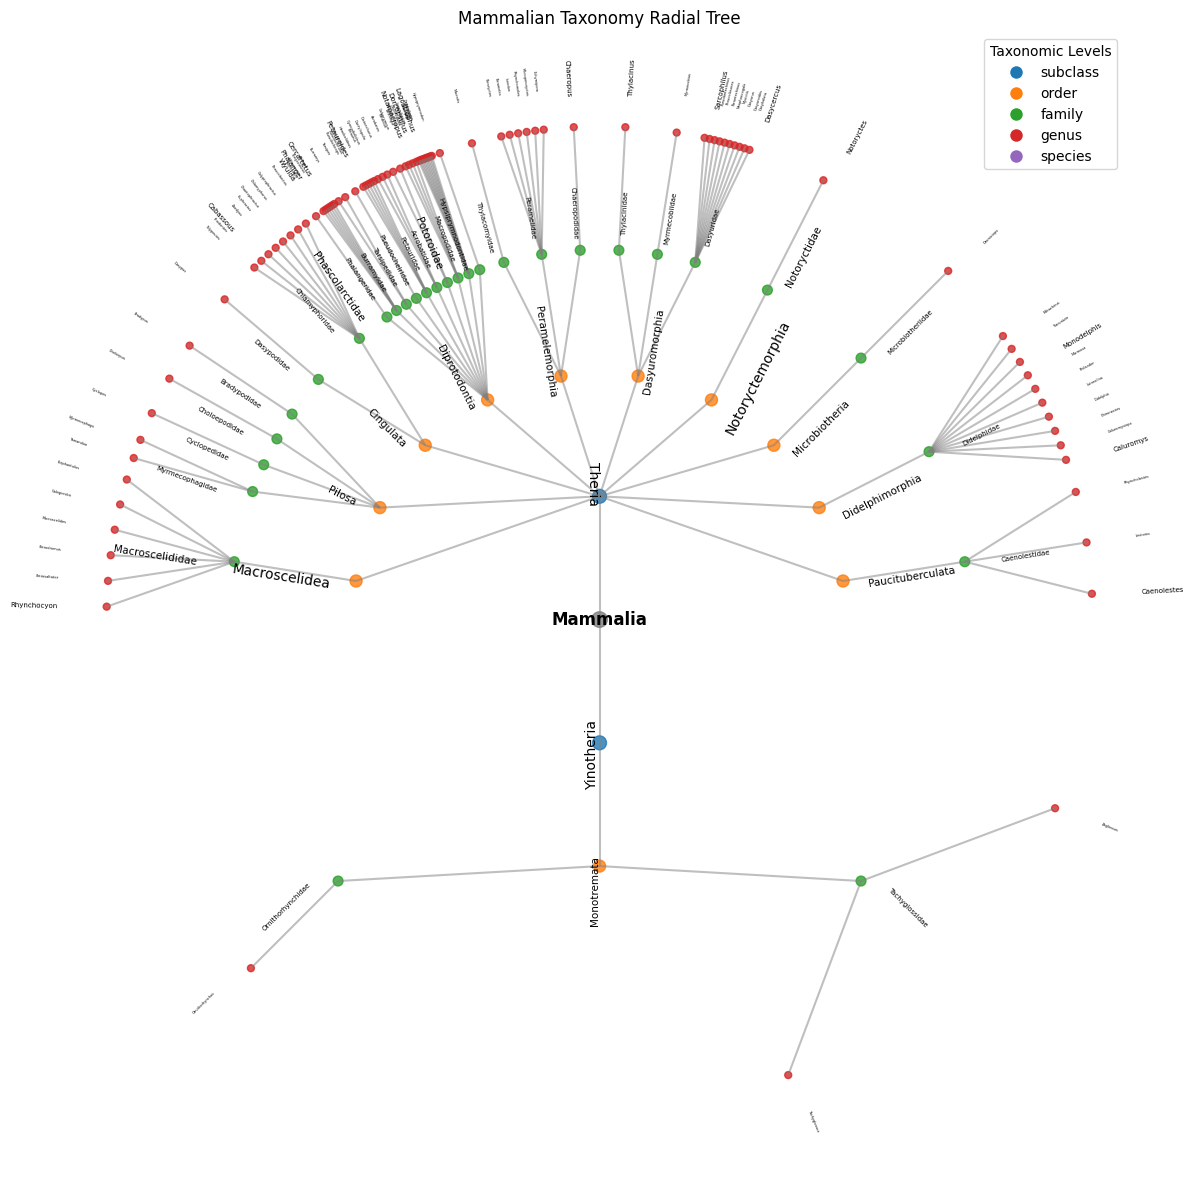

In [ ]:
def plot_radial_tree(ontology, max_depth=4, figsize=(12, 12)):
    """
    Create a radial tree visualization of the taxonomy.

    Parameters:
    -----------
    ontology : dict
        The ontology to visualize
    max_depth : int
        Maximum depth to display
    figsize : tuple
        Figure size
    """
    plt.figure(figsize=figsize)

    # Track all nodes and their positions
    nodes = []
    labels = []
    colors = []
    node_sizes = []
    lines = []

    # Color mapping for node types
    color_map = {
        'subclass': 'tab:blue',
        'order': 'tab:orange',
        'family': 'tab:green',
        'genus': 'tab:red',
        'species': 'tab:purple'
    }

    # Recursive function to process nodes
    def process_node(node, angle, radius, angle_width, depth=0):
        if depth > max_depth:
            return

        # Convert polar coordinates to Cartesian
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)

        # Store node information
        nodes.append((x, y))
        labels.append(node['name'])

        # Determine node color and size
        node_type = node.get('type', 'unknown')
        colors.append(color_map.get(node_type, 'tab:gray'))

        # Larger nodes for higher levels
        node_sizes.append(100 * (max_depth - depth + 1) / max_depth)

        # Process children
        if 'children' in node and node['children'] and depth < max_depth:
            children = node['children']
            n_children = len(children)

            # If too many children, sample some
            if n_children > 10:
                children = children[:10]
                n_children = 10

            # Calculate angles for children
            child_angle_width = angle_width / n_children

            for i, child in enumerate(children):
                child_angle = angle - angle_width/2 + child_angle_width/2 + i*child_angle_width
                child_radius = radius + 1  # Move out one level

                # Add line connecting parent to child
                child_x = child_radius * np.cos(child_angle)
                child_y = child_radius * np.sin(child_angle)
                lines.append([(x, y), (child_x, child_y)])

                # Process child node
                process_node(child, child_angle, child_radius, child_angle_width, depth + 1)

    # Start with the root node at the center
    process_node(ontology, 0, 0, 2*np.pi)

    # Plot the tree
    plt.scatter(*zip(*nodes), s=node_sizes, c=colors, alpha=0.8)

    # Add node labels, with adjustments for better readability
    for (x, y), label, size in zip(nodes, labels, node_sizes):
        # Calculate distance from center (radius)
        r = np.sqrt(x**2 + y**2)

        # Skip the center label (will be drawn separately)
        if r < 0.1:
            plt.text(0, 0, label, ha='center', va='center', fontsize=12, fontweight='bold')
            continue

        # Calculate angle for text rotation
        angle = np.arctan2(y, x)
        rotation = np.degrees(angle)

        # Adjust rotation for readability
        if -90 < rotation < 90:
            ha = 'left'
            # Keep the rotation as is
        else:
            ha = 'right'
            rotation = rotation - 180

        # Adjust font size based on node size and distance from center
        font_size = 10 * (max_depth - np.floor(r) + 1) / max_depth

        # Position text slightly away from node
        text_distance = 1.1  # Multiplier for distance
        text_x = text_distance * x
        text_y = text_distance * y

        plt.text(text_x, text_y, label, ha=ha, va='center',
                 fontsize=font_size, rotation=rotation)

    # Add connecting lines
    line_segments = LineCollection(lines, colors='gray', alpha=0.5, linestyle='-')
    plt.gca().add_collection(line_segments)

    # Create legend for node types
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=color, markersize=10,
                                 label=node_type)
                       for node_type, color in color_map.items()]
    plt.legend(handles=legend_elements, title="Taxonomic Levels")

    # Set plot limits and remove axes
    plt.axis('equal')
    plt.axis('off')
    plt.title('Mammalian Taxonomy Radial Tree')
    plt.tight_layout()
    plt.show()

# Visualize the taxonomy as a radial tree
plot_radial_tree(taxonomic_ontology, max_depth=4)

# Orders

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


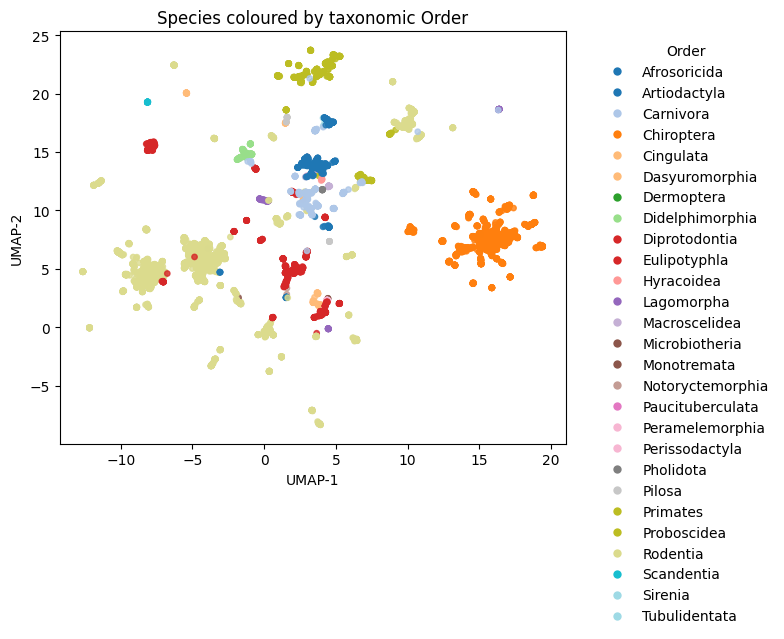

In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines

# Compute UMAP embeddings (assuming 'embeddings' is your high-dimensional data)
reducer = umap.UMAP(random_state=42)
u = reducer.fit_transform(emb)  # define embeddings accordingly

orders = df_small["Order"].fillna("Unknown")
order_codes = orders.astype("category").cat.codes
unique_orders = orders.astype("category").cat.categories

# Build a categorical colormap with enough distinct hues
cmap = mpl.colors.ListedColormap(
    mpl.cm.tab20(np.linspace(0, 1, len(unique_orders)))
)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(u[:, 0], u[:, 1],
                c=order_codes,
                cmap=cmap,
                s=15, alpha=.8)

# Legend handles: use mlines.Line2D
handles = [
    mlines.Line2D([0], [0], marker='o', linestyle='',
                  markerfacecolor=cmap(i), markersize=6,
                  markeredgewidth=0, label=ordr)
    for i, ordr in enumerate(unique_orders)
]

ax.legend(handles=handles,
          bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Order", frameon=False)
ax.set_title("Species coloured by taxonomic Order")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
plt.tight_layout(); plt.show()


## Print unique orders per cluster with counts

In [ ]:
# Make sure rows are sorted predictably
tmp = df_small.sort_values(["cluster", "Species"])

# Print unique orders per cluster with counts
for c in sorted(tmp["cluster"].unique()):
    print(f"\n— Cluster {c} —")
    counts = tmp[tmp["cluster"] == c]["Order"].value_counts()
    for order, count in counts.items():
        print(f"{order}: {count}")


— Cluster 0 —
Carnivora: 22

— Cluster 1 —
Chiroptera: 183

— Cluster 2 —
Eulipotyphla: 188

— Cluster 3 —
Chiroptera: 675
Carnivora: 1

— Cluster 4 —
Carnivora: 4

— Cluster 5 —
Rodentia: 6

— Cluster 6 —
Artiodactyla: 24

— Cluster 7 —
Dasyuromorphia: 2

— Cluster 8 —
Rodentia: 95

— Cluster 9 —
Carnivora: 3
Primates: 1

— Cluster 10 —
Carnivora: 10

— Cluster 11 —
Rodentia: 501
Eulipotyphla: 1
Diprotodontia: 1

— Cluster 12 —
Artiodactyla: 26

— Cluster 13 —
Diprotodontia: 47

— Cluster 14 —
Artiodactyla: 93

— Cluster 15 —
Rodentia: 158

— Cluster 16 —
Rodentia: 193

— Cluster 17 —
Chiroptera: 62

— Cluster 18 —
Artiodactyla: 8

— Cluster 19 —
Perissodactyla: 4
Artiodactyla: 3

— Cluster 20 —
Lagomorpha: 31

— Cluster 21 —
Rodentia: 52

— Cluster 22 —
Artiodactyla: 30

— Cluster 23 —
Rodentia: 23
Eulipotyphla: 12
Afrosoricida: 1

— Cluster 24 —
Carnivora: 9
Afrosoricida: 3

— Cluster 25 —
Rodentia: 150

— Cluster 26 —
Primates: 85

— Cluster 27 —
Diprotodontia: 7
Notoryctemorphia:

# Calculate Mean Cluster Purity by Order

In [ ]:
import numpy as np

def mean_purity_from_labels(labels, orders):
    purities = []
    for k in np.unique(labels):
        idx     = np.where(labels == k)[0]
        ords    = orders.iloc[idx]
        top     = ords.value_counts().iloc[0]
        purities.append(top / len(ords))
    return np.mean(purities)

orders = df_small["Order"]
print("Mean cluster purity by Order:", mean_purity_from_labels(labels, orders))


Mean cluster purity by Order: 0.9680466334879285


# Families

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-29-d6475e3022bb>:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


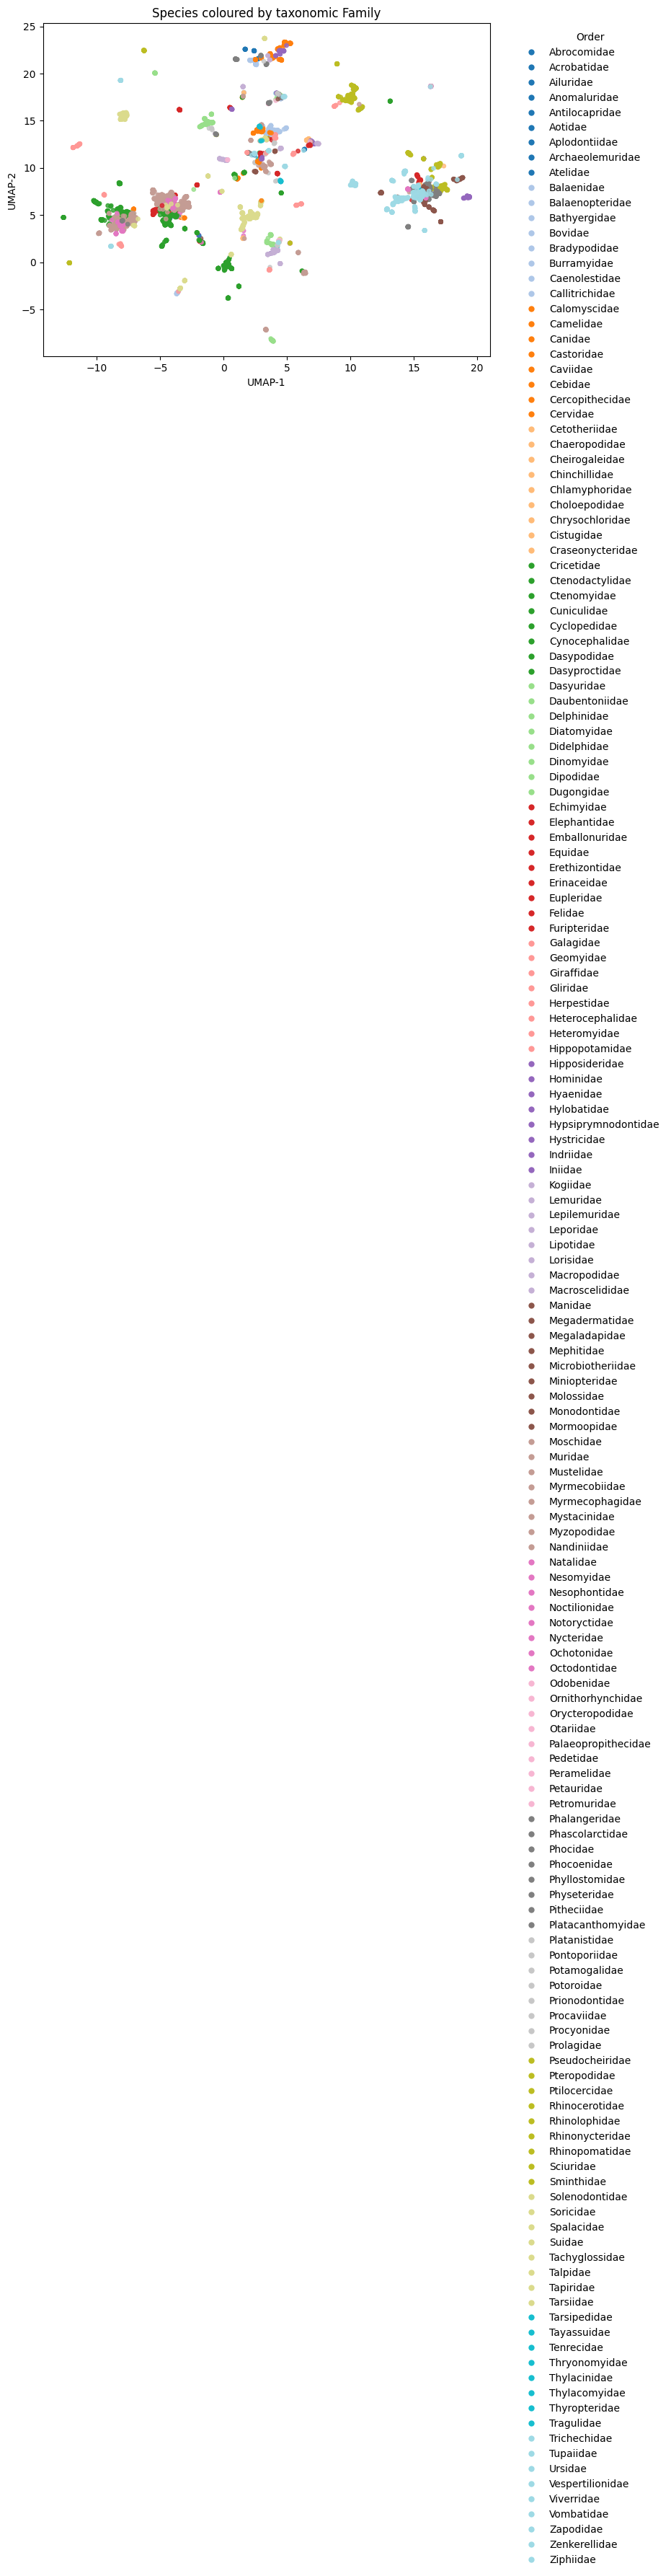

In [ ]:

# Compute UMAP embeddings (assuming 'embeddings' is your high-dimensional data)
reducer = umap.UMAP(random_state=42)
u = reducer.fit_transform(emb)  # define embeddings accordingly

orders = df_small["Family"].fillna("Unknown")
order_codes = orders.astype("category").cat.codes
unique_orders = orders.astype("category").cat.categories

# Build a categorical colormap with enough distinct hues
cmap = mpl.colors.ListedColormap(
    mpl.cm.tab20(np.linspace(0, 1, len(unique_orders)))
)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(u[:, 0], u[:, 1],
                c=order_codes,
                cmap=cmap,
                s=15, alpha=.8)

# Legend handles: use mlines.Line2D
handles = [
    mlines.Line2D([0], [0], marker='o', linestyle='',
                  markerfacecolor=cmap(i), markersize=6,
                  markeredgewidth=0, label=ordr)
    for i, ordr in enumerate(unique_orders)
]

ax.legend(handles=handles,
          bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Order", frameon=False)
ax.set_title("Species coloured by taxonomic Family")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
plt.tight_layout(); plt.show()


# Print unique Families per cluster with counts

In [ ]:
# Make sure rows are sorted predictably
tmp = df_small.sort_values(["cluster", "Species"])

# Print unique families per cluster with counts
for c in sorted(tmp["cluster"].unique()):
    print(f"\n— Cluster {c} —")
    counts = tmp[tmp["cluster"] == c]["Family"].value_counts()
    for order, count in counts.items():
        print(f"{order}: {count}")


— Cluster 0 —
Mustelidae: 22

— Cluster 1 —
Rhinolophidae: 111
Hipposideridae: 72

— Cluster 2 —
Soricidae: 188

— Cluster 3 —
Phyllostomidae: 197
Vespertilionidae: 168
Pteropodidae: 113
Emballonuridae: 49
Molossidae: 46
Hipposideridae: 22
Mormoopidae: 18
Nycteridae: 14
Natalidae: 11
Rhinonycteridae: 9
Rhinolophidae: 7
Rhinopomatidae: 5
Thyropteridae: 5
Furipteridae: 2
Noctilionidae: 2
Cistugidae: 2
Mystacinidae: 2
Myzopodidae: 2
Craseonycteridae: 1
Canidae: 1

— Cluster 4 —
Eupleridae: 4

— Cluster 5 —
Echimyidae: 5
Octodontidae: 1

— Cluster 6 —
Cervidae: 14
Tragulidae: 10

— Cluster 7 —
Dasyuridae: 2

— Cluster 8 —
Sciuridae: 95

— Cluster 9 —
Phocidae: 3
Pitheciidae: 1

— Cluster 10 —
Hyaenidae: 5
Mustelidae: 4
Herpestidae: 1

— Cluster 11 —
Muridae: 434
Nesomyidae: 27
Cricetidae: 16
Echimyidae: 15
Spalacidae: 6
Octodontidae: 2
Erinaceidae: 1
Hypsiprymnodontidae: 1
Thryonomyidae: 1

— Cluster 12 —
Cervidae: 26

— Cluster 13 —
Pseudocheiridae: 20
Petauridae: 13
Phalangeridae: 5
Bur

# Calculate Mean Cluster Purity by Family

In [ ]:
import numpy as np

def mean_purity_from_labels(labels, families):
    purities = []
    for k in np.unique(labels):
        idx     = np.where(labels == k)[0]
        fams    = families.iloc[idx]
        top     = fams.value_counts().iloc[0]
        purities.append(top / len(fams))
    return np.mean(purities)

families = df_small["Family"]
print("Mean cluster purity by Family:", mean_purity_from_labels(labels, families))


Mean cluster purity by Family: 0.8786195227870482


# Genus

# Print unique Genus per cluster with counts

In [ ]:
# Make sure rows are sorted predictably
tmp = df_small.sort_values(["cluster", "Species"])

# Print unique families per cluster with counts
for c in sorted(tmp["cluster"].unique()):
    print(f"\n— Cluster {c} —")
    counts = tmp[tmp["cluster"] == c]["Genus"].value_counts()
    for order, count in counts.items():
        print(f"{order}: {count}")


— Cluster 0 —
Mustela: 17
Meles: 4
Vormela: 1

— Cluster 1 —
Rhinolophus: 111
Hipposideros: 72

— Cluster 2 —
Sorex: 84
Cryptotis: 53
Sylvisorex: 11
Episoriculus: 6
Notiosorex: 6
Soriculus: 4
Chodsigoa: 4
Blarina: 4
Congosorex: 2
Blarinella: 2
Scutisorex: 2
Paracrocidura: 2
Parablarinella: 1
Palawanosorex: 1
Feroculus: 1
Megasorex: 1
Solisorex: 1
Ruwenzorisorex: 1
Pseudosoriculus: 1
Surdisorex: 1

— Cluster 3 —
Platyrrhinus: 19
Plecotus: 18
Eumops: 17
Nyctophilus: 17
Pteronotus: 16
Dobsonia: 14
Nycteris: 14
Taphozous: 14
Lonchophylla: 13
Micronycteris: 13
Glauconycteris: 13
Artibeus: 13
Epomophorus: 11
Histiotus: 11
Dermanura: 11
Anoura: 10
Myotis: 9
Glossophaga: 9
Vespadelus: 8
Emballonura: 8
Chalinolobus: 8
Carollia: 8
Lophostoma: 8
Rousettus: 7
Natalus: 7
Tadarida: 7
Chiroderma: 7
Cynopterus: 7
Rhinolophus: 7
Lonchorhina: 6
Tylonycteris: 6
Rhogeessa: 5
Thyroptera: 5
Uroderma: 5
Pteralopex: 5
Saccopteryx: 5
Glischropus: 5
Macronycteris: 5
Nyctinomops: 5
Myonycteris: 5
Lasiurus: 5
La

# Calculate Mean Cluster Purity by Genus

In [ ]:
import numpy as np

def mean_purity_from_labels(labels, genuses):
    purities = []
    for k in np.unique(labels):
        idx     = np.where(labels == k)[0]
        gens    = genuses.iloc[idx]
        top     = gens.value_counts().iloc[0]
        purities.append(top / len(gens))
    return np.mean(purities)

genuses = df_small["Genus"]
print("Mean cluster purity by Genus:", mean_purity_from_labels(labels, genuses))

Mean cluster purity by Genus: 0.5814788731014108


In [ ]:
def calculate_purity_metrics(df, labels):
    """
    Calculate purity metrics for different taxonomic levels.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing taxonomic information
    labels : numpy array
        Cluster assignments

    Returns:
    --------
    metrics : dict
        Dictionary of purity metrics
    """
    metrics = {}

    # Function to calculate purity for a given column
    def mean_purity_by_column(column):
        purities = []
        for k in np.unique(labels):
            idx = np.where(labels == k)[0]
            col_values = df.iloc[idx][column]
            if len(col_values) > 0:
                top = col_values.value_counts().iloc[0]
                purities.append(top / len(col_values))
        return np.mean(purities)

    # Calculate purity for different taxonomic levels
    for column in ["Order", "Family", "Genus"]:
        if column in df.columns:
            purity = mean_purity_by_column(column)
            metrics[f"Mean cluster purity by {column}"] = purity
            print(f"Mean cluster purity by {column}: {purity:.3f}")

    # Calculate silhouette score
    silhouette = silhouette_score(reduced_emb, labels)
    metrics["Silhouette score"] = silhouette
    print(f"Silhouette score: {silhouette:.3f}")

    return metrics

# Calculate purity metrics
metrics = calculate_purity_metrics(df_small, labels)

Mean cluster purity by Order: 0.968
Mean cluster purity by Family: 0.879
Mean cluster purity by Genus: 0.581
Silhouette score: 0.128
